# From notebook to package

Demonstration notebook for purpose of transforming it into a Python package.

Code used from a course by Michael Zingale. See https://zingale.github.io/computational_astrophysics/intro.html

The code follows Michael's section on ODE, and cells are in order the code is presented in the online lecture notes. Comment cells are by ER.

Import statements are done locally, where and when they are needed; this is to mimic an organic development of writing the code, for example when exploring data and more utility packages are needed. Local import statements keeps the focus on that section of the notebook, instead of having to go to the start, add another import to a list of imports, execute the cell, then go back to the cell where the focus actually is.

## Goal

Write and compare three integrators for ordinary differential equations. In particular, we create the simplests, using Euler's method, then create a second and fourth order Runge-Kutta integrator.

### `OrbitState`

Helper class to keep position and velocity state

Adding or subtracting two states will add the individual components. Multiplying by a number will multiply each individual component. This is very much the same behaviour like a NumPy array, except that there is no addition with a number, nor multiplication with another state.

In [1]:
class OrbitState:
    # a container to hold the star positions
    def __init__(self, x, y, u, v):
        self.x = x
        self.y = y
        self.u = u
        self.v = v

    def __add__(self, other):
        return OrbitState(self.x + other.x, self.y + other.y,
                          self.u + other.u, self.v + other.v)

    def __sub__(self, other):
        return OrbitState(self.x - other.x, self.y - other.y,
                          self.u - other.u, self.v - other.v)

    def __mul__(self, other):
        return OrbitState(other * self.x, other * self.y,
                          other * self.u, other * self.v)

    def __rmul__(self, other):
        return self.__mul__(other)

    def __str__(self):
        return f"{self.x:10.6f} {self.y:10.6f} {self.u:10.6f} {self.v:10.6f}"

Write the actual equations, calculating the right hand side, and returning the left hand side. 

The actual equations are simply


$$\dot{\bf r} = {\bf v}$$

$$\dot{\bf v} = -\frac{GM_\star {\bf r}}{r^3}$$

where ${\bf r} = (x, y)$ and ${\bf v} = (u, v)$.


In [2]:
import numpy as np

GM = 4*np.pi**2

def rhs(state):
    """ RHS of the equations of motion."""

    # current radius
    r = np.sqrt(state.x**2 + state.y**2)

    # position
    xdot = state.u
    ydot = state.v

    # velocity
    udot = -GM * state.x / r**3
    vdot = -GM * state.y / r**3

    return OrbitState(xdot, ydot, udot, vdot)

Using Euler's method, which is one of the most simplest, straightforwardest methods.

In [3]:
def euler_orbit(state0, tau, T):
    """integrate an orbit given an initial position, pos0, and velocity, vel0,
    using first-order Euler integration"""
    
    times = []
    history = []
    
    # initialize time
    t = 0
    
    # store the initial conditions
    times.append(t)
    history.append(state0)
    
    # main timestep loop
    while t < T:
        
        state_old = history[-1]
        
        # make sure that the last step does not take us past T
        if t + tau > T:
            tau = T - t

        # get the RHS
        ydot = rhs(state_old)
        
        # do the Euler update
        state_new = state_old + tau * ydot
        t += tau
        
        # store the state
        times.append(t)
        history.append(state_new)
        
    return times, history

Set an initial state: position at the "top" (y = 1), and speed along the x-axis.

In [4]:
x0 = 0
y0 = 1
u0 = -np.sqrt(GM/y0)
v0 = 0

state0 = OrbitState(x0, y0, u0, v0)

For a year (`T = 1`), perform integrations (timestepping) with one month intervals.

In [5]:
T = 1
tau = T/12.0

times, history = euler_orbit(state0, tau, 1)

Text(0, 0.5, 'y [AU]')

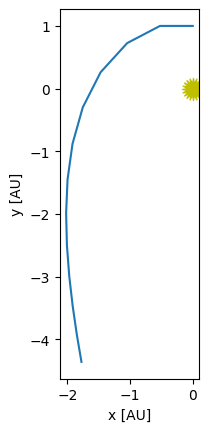

In [6]:
import matplotlib.pyplot as plt

fig = plt.figure()
ax = fig.add_subplot(111)

xs = [q.x for q in history]
ys = [q.y for q in history]

# draw the Sun
ax.scatter([0], [0], marker=(20,1), color="y", s=250)

# draw the orbit
ax.plot(xs, ys)

ax.set_aspect("equal")
ax.set_xlabel("x [AU]")
ax.set_ylabel("y [AU]")

That went bad very quickly.
Try with different, smaller timesteps: ~1 month, ~1/2 week, ~8 hours 

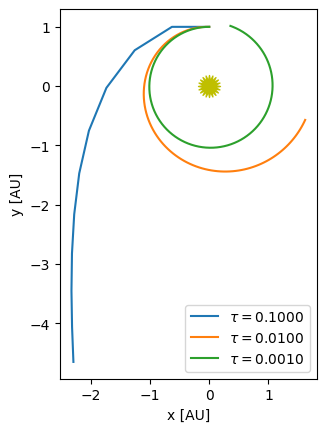

In [7]:
fig = plt.figure()
ax = fig.add_subplot(111)

# draw the Sun
ax.scatter([0], [0], marker=(20,1), color="y", s=250)

taus = [0.1, 0.01, 0.001]

for tau in taus:
    times, history = euler_orbit(state0, tau, 1)
    xs = [q.x for q in history]
    ys = [q.y for q in history]
    ax.plot(xs, ys, label=rf"$\tau = {tau:6.4f}$")

ax.set_aspect("equal")
ax.legend()
ax.set_xlabel("x [AU]")
ax.set_ylabel("y [AU]");

Turn the plotting into a function

In [8]:
def initial_conditions():
    x0 = 0
    y0 = 1
    u0 = -np.sqrt(GM / y0)
    v0 = 0

    return OrbitState(x0, y0, u0, v0)

In [9]:
def plot(history, ax=None, label=None):
    """make a plot of the solution.  If ax is None we setup a figure
    and make the entire plot returning the figure object, otherwise, we
    just append the plot to a current axis"""

    fig = None

    if ax is None:
        fig = plt.figure()
        ax = fig.add_subplot(111)

        # draw the Sun
        ax.scatter([0], [0], marker=(20,1), color="y", s=250)

    # draw the orbit
    xs = [q.x for q in history]
    ys = [q.y for q in history]

    ax.plot(xs, ys, label=label)

    if fig is not None:
        ax.set_aspect("equal")
        ax.set_xlabel("x [AU]")
        ax.set_ylabel("y [AU]")

    return fig

### Runge Kutta integrator

Write a simple second order Runge Kutta integrator

In [10]:
def int_rk2(state0, tau, T):

    times = []
    history = []
    
    # initialize time
    t = 0
    
    # store the initial conditions
    times.append(t)
    history.append(state0)
    
    # main timestep loop
    while t < T:
        
        state_old = history[-1]
        
        # make sure that the last step does not take us past T
        if t + tau > T:
            tau = T - t

        # get the RHS
        ydot = rhs(state_old)
    
        # predict the state at the midpoint
        state_tmp = state_old + 0.5 * tau * ydot
        
        # evaluate the RHS at the midpoint
        ydot = rhs(state_tmp)
        
        # do the final update
        state_new = state_old + tau * ydot
        t += tau
        
        # store the state
        times.append(t)
        history.append(state_new)
        
    return times, history

Try the new integrator with 1 month timestep

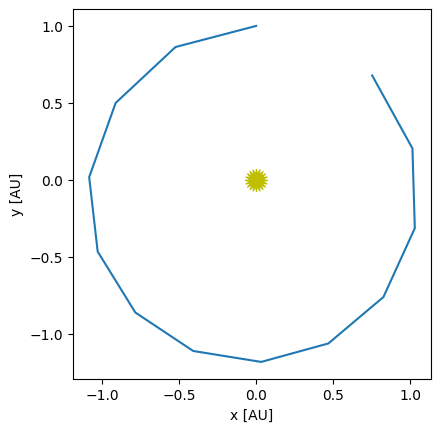

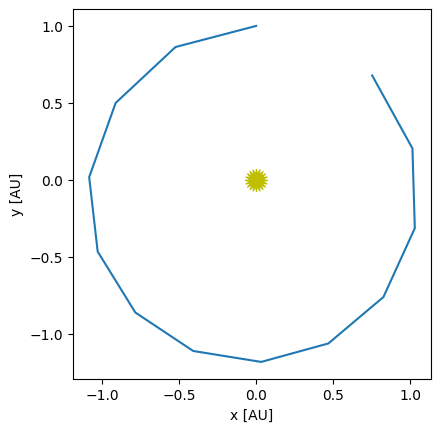

In [11]:
T = 1
tau = T/12.0

state0 = OrbitState(0, 1, -np.sqrt(GM / y0), 0)

times, history = int_rk2(state0, tau, 1)
plot(history)

That looks a lot better. How about smaller timesteps?

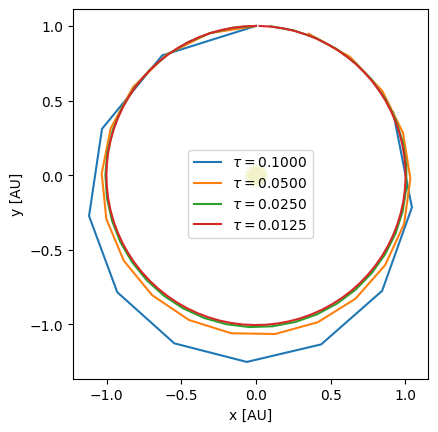

In [12]:
taus = [0.1, 0.05, 0.025, 0.0125]

for n, tau in enumerate(taus):
    times, history = int_rk2(state0, tau, 1)
    
    if n == 0:
        fig = plot(history, label=rf"$\tau = {tau:6.4f}$")
    else:
        plot(history, ax=fig.gca(), label=rf"$\tau = {tau:6.4f}$")
        
fig.gca().legend()

### Fourth order Runge Kutta integrator

Can we do even better, with a higher order integrator?

Below is a simple fourth order Runge Kutta integrator, RK4.

In [13]:
def int_rk4(state0, tau, T):

    times = []
    history = []
    
    # initialize time
    t = 0
    
    # store the initial conditions
    times.append(t)
    history.append(state0)
    
    # main timestep loop
    while t < T:
        
        state_old = history[-1]
        
        # make sure that the last step does not take us past T
        if t + tau > T:
            tau = T - t

        # get the RHS
        k1 = rhs(state_old)
         
        state_tmp = state_old + 0.5 * tau * k1
        k2 = rhs(state_tmp)
        
        state_tmp = state_old + 0.5 * tau * k2
        k3 = rhs(state_tmp)
        
        state_tmp = state_old + tau * k3
        k4 = rhs(state_tmp)
        
        # do the final update
        state_new = state_old + tau / 6.0 * (k1 + 2*k2 + 2*k3 + k4)
        t += tau
        
        # store the state
        times.append(t)
        history.append(state_new)
        
    return times, history

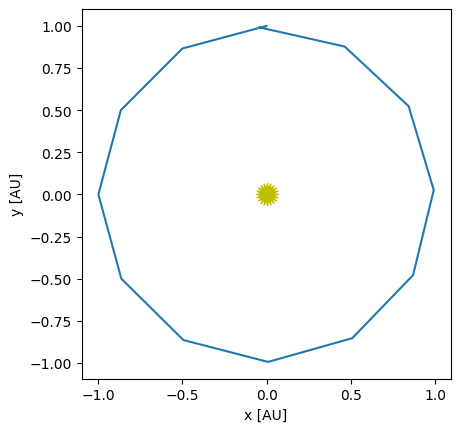

In [14]:
state0 = initial_conditions()

tau = 1.0/12.0

times, history = int_rk4(state0, tau, 1)

fig = plot(history)

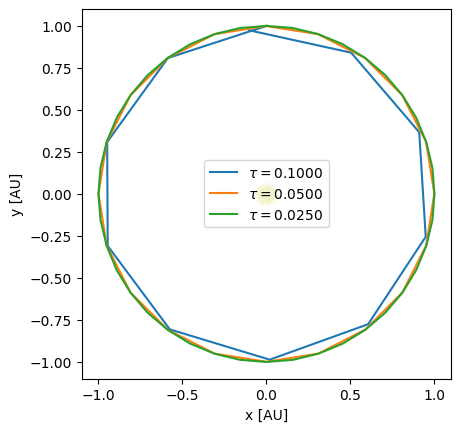

In [15]:
taus = [0.1, 0.05, 0.025]

for n, tau in enumerate(taus):
    times, history = int_rk4(state0, tau, 1)
    
    if n == 0:
        fig = plot(history, label=rf"$\tau = {tau:6.4f}$")
    else:
        plot(history, ax=fig.gca(), label=rf"$\tau = {tau:6.4f}$")

fig.gca().legend()

These results are definitely even better. At the cost of more calculations of our `rhs` function, so this shouldn't become too expensive to calculate.

Now let's try for an elliptical orbit; a slightly different innitial condition

In [16]:
a = 1.0
e = 0.6

x0 = 0
y0 = a * (1 - e)
u0 = -np.sqrt(GM / a * (1 + e)/(1 - e))
v0 = 0

state0 = OrbitState(x0, y0, u0, v0)

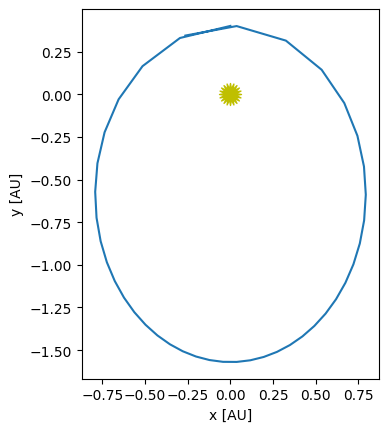

In [17]:
tau = 0.025
T = 1

times, history = int_rk4(state0, tau, 1)

fig = plot(history)

Still pretty good, with a ~1 week time step.